https://www.kaggle.com/datasets/wojtekbonicki/bitcoin-data

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
df = pd.read_csv('data.csv')
df.head()

,Date,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
0,2014-01-02,749.27,54770.0,0.18,8,1225.0,1831.98,95.14,11089.3
1,2014-01-03,781.23,60980.0,NaN,8,1238.4,1831.37,93.66,11089.3
2,2014-01-04,807.39,52052.0,NaN,8,NaN,NaN,NaN,11089.3
3,2014-01-05,828.74,58662.0,0.38,8,NaN,NaN,NaN,11089.3
4,2014-01-06,904.98,67358.0,NaN,8,1237.8,1826.77,93.12,11089.3


In [65]:
df=df.dropna()
df.reset_index()
df.head()

,Date,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
0,2014-01-02,749.27,54770.0,0.18,8,1225.0,1831.98,95.14,11089.3
6,2014-01-08,790.00,61439.0,0.18,8,1225.3,1837.49,91.90,11089.3
12,2014-01-14,823.00,57378.0,0.22,8,1245.2,1838.88,92.15,11089.3
15,2014-01-17,817.15,59026.0,0.19,8,1251.7,1838.70,93.96,11089.3
21,2014-01-23,819.62,63576.0,0.19,8,1262.6,1828.46,97.23,11089.3


In [66]:
df['Date'] = pd.to_datetime(df['Date'])

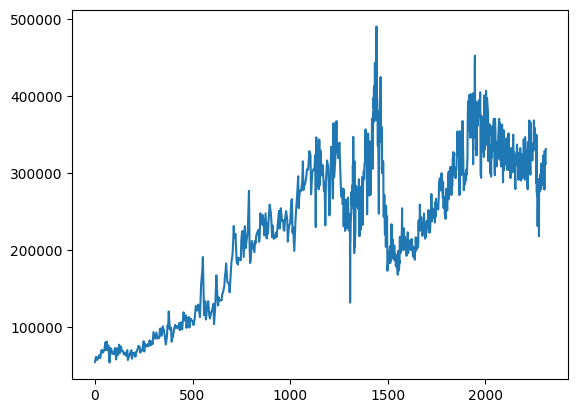

In [67]:
plt.plot(df.index,df['n-transactions'])
plt.show()

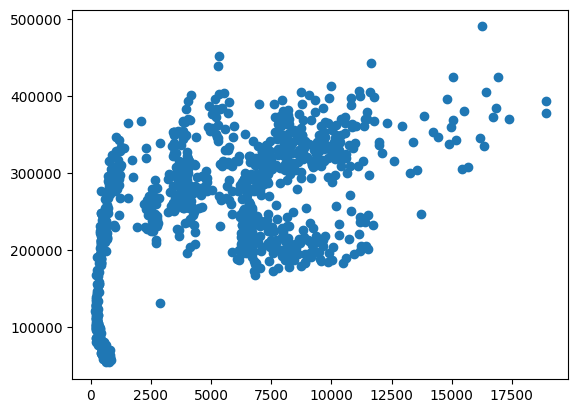

In [68]:
plt.scatter(df['BTC price [USD]'],df['n-transactions'])
plt.show()

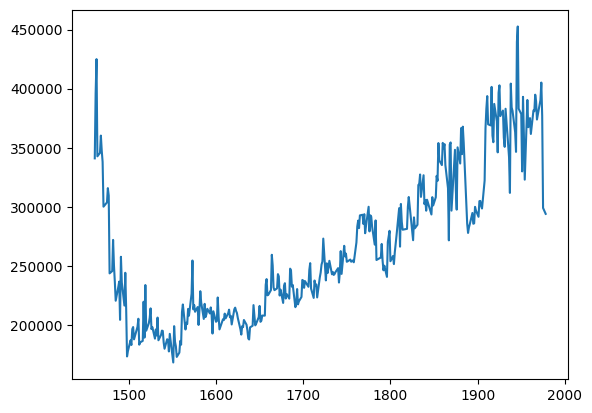

In [81]:
filtered_df = df[df["Date"].isin(pd.date_range('2018-01-01', '2019-06-03'))]
plt.plot(filtered_df.index,filtered_df['n-transactions'])
plt.show()

In [82]:
filtered_df.shape

(353, 9)